# Feedback Dataset CSV

# Import Packages

Import Azure ML and other packages used in this demo. We will be using NOAA ISD Azure Open Dataset to demonstrate data drift.

In [1]:
# recommend using a clean conda environment

# install packages 
!pip install --upgrade pip
!pip install tqdm
!pip install azureml-contrib-opendatasets
!pip install lightgbm
!pip install matplotlib

Requirement already up-to-date: pip in /home/cody/.local/lib/python3.7/site-packages (19.1.1)


In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from datetime import datetime, timedelta

from azureml.contrib.opendatasets import NoaaIsdWeather

# Configuration

Configure start date, number of days to use in training a model to predict temperature, and number of days to analyze drift on. Modify code to run drift anlaysis on different number of days of inference data. Will make this easily variable for public release. 

In [3]:
# start of training dataset
start_train = datetime(year=2010, month=1, day=1)
end_train   = datetime(year=2010, month=1, day=31)

start_infer = datetime(year=2010, month=2, day=1)
end_infer   = datetime(year=2010, month=2, day=28)

features = ['usaf',
    'wban',
    'latitude',
    'longitude',
    'elevation',
    'windAngle',
    'windSpeed',
    'temperature',
    'seaLvlPressure',
    'cloudCoverage',
    'presentWeatherIndicator',
    'pastWeatherIndicator',
    'precipTime',
    'precipDepth',
    'snowDepth',
    'stationName',
    'countryOrRegion',
    'p_k']

schema = {feature:None for feature in features}

schema['datetime'] = None
schema['version'] = None
schema['service'] = None
schema['predicted_temperature'] = None

In [4]:
def get_data(start, end):

    isd = NoaaIsdWeather(start, end)
    df = isd.to_pandas_dataframe()
    
    df = df.dropna().drop_duplicates()
    
    target = 'temperature'
    
    # need Kin to help with not dropping these...
    x_df = df.drop(target, axis=1).drop('datetime', axis=1).drop(['usaf', 'wban', 'cloudCoverage', 'stationName', 'countryOrRegion', 'p_k'], axis=1)
    y_df = df[[target]]
    
    return df, x_df, y_df

In [5]:
%%time

train, x_train, y_train = get_data(start_train, end_train)
infer, x_infer, y_infer = get_data(start_infer, end_infer)

x_infer.index=range(x_infer.shape[0])
y_infer.index=range(y_infer.shape[0])

ActivityStarted, to_pandas_dataframe
Target paths: ['/year=2010/month=1/']
Looking for parquet files...
Reading them into Pandas dataframe...
Reading ISDWeather/year=2010/month=1/part-00009-tid-2760641154746282667-d6a50598-0478-455f-9217-ce4afb96a9bb-36.c000.snappy.parquet under container isdweatherdatacontainer
Done.
ActivityCompleted: Activity=to_pandas_dataframe, HowEnded=Success, Duration=35616.1 [ms]
ActivityStarted, to_pandas_dataframe
Target paths: ['/year=2010/month=2/']
Looking for parquet files...
Reading them into Pandas dataframe...
Reading ISDWeather/year=2010/month=2/part-00011-tid-2760641154746282667-d6a50598-0478-455f-9217-ce4afb96a9bb-38.c000.snappy.parquet under container isdweatherdatacontainer
Done.
ActivityCompleted: Activity=to_pandas_dataframe, HowEnded=Success, Duration=20950.74 [ms]
CPU times: user 21.8 s, sys: 40.4 s, total: 1min 2s
Wall time: 1min 8s


In [6]:
x_df = x_train
y_df = y_train

def model1():
    train_set = lgb.Dataset(data=x_df, label=y_df)

    params = {'learning_rate'    : 0.1,
              'boosting'         : 'gbdt',
              'metric'           : 'rmse',
              'feature_fraction' : 1,
              'bagging_fraction' : 1,
              'max_depth': 6,
              'num_leaves'       : 31,
              'objective'        : 'regression',
              'bagging_freq'     : 1,
              "verbose": -1,
              'min_data_per_leaf': 100}


    model = lgb.train(params, 
                      num_boost_round=500,
                      train_set=train_set,
                      verbose_eval=50)
    
    return model, 'modelA', 1, 'aks_cluster'

def model2():
    train_set = lgb.Dataset(data=x_df, label=y_df)

    params = {'learning_rate'    : 0.2,
              'boosting'         : 'gbdt',
              'metric'           : 'rmse',
              'feature_fraction' : 1,
              'bagging_fraction' : 1,
              'max_depth': 6,
              'num_leaves'       : 62,
              'objective'        : 'regression',
              'bagging_freq'     : 1,
              "verbose": -1,
              'min_data_per_leaf': 50}


    model = lgb.train(params, 
                      num_boost_round=500,
                      train_set=train_set,
                      verbose_eval=50)
    
    return model, 'modelA', 2, 'aks_cluster'

def model3():
    train_set = lgb.Dataset(data=x_df, label=y_df)

    params = {'learning_rate'    : 0.1,
              'boosting'         : 'gbdt',
              'metric'           : 'rmse',
              'feature_fraction' : 1,
              'bagging_fraction' : 1,
              'max_depth': 6,
              'num_leaves'       : 127,
              'objective'        : 'regression',
              'bagging_freq'     : 1,
              "verbose": -1,
              'min_data_per_leaf': 100}


    model = lgb.train(params, 
                      num_boost_round=5,
                      train_set=train_set,
                      verbose_eval=50)
    
    return model, 'modelA', 3, 'aks_cluster'

def model4():
    train_set = lgb.Dataset(data=x_df, label=y_df)

    params = {'learning_rate'    : 0.4,
              'boosting'         : 'gbdt',
              'metric'           : 'rmse',
              'feature_fraction' : 1,
              'bagging_fraction' : 1,
              'max_depth': 6,
              'num_leaves'       : 31,
              'objective'        : 'regression',
              'bagging_freq'     : 1,
              "verbose": -1,
              'min_data_per_leaf': 100}


    model = lgb.train(params, 
                      num_boost_round=500,
                      train_set=train_set,
                      verbose_eval=50)
    
    return model, 'modelA', 4, 'aks_cluster'

In [7]:
header = True

for m in tqdm([model1, model2, model3, model4]):

    model, model_name, model_version, service_name = m()
    
    pred = model.predict(x_infer)
    temp_pred = pd.DataFrame(pred, columns=['temperature_prediction'])
    interpret(model, x_infer, temp_pred)
    temp_pred['model_name'] = model_name
    temp_pred['model_version'] = model_version
    temp_pred['service_name'] = service_name

    infer.index=range(infer.shape[0])

    dataset = temp_pred.merge(infer, left_index=True, right_index=True)
        
    with open('dataset.csv', 'a') as f:
        dataset.to_csv(f, header=header)
        
    header = False

100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


In [8]:
dataset = pd.read_csv('feedbackv2.csv')
dataset.head()

,Unnamed: 0,temperature_prediction,model_name,model_version,service_name,usaf,wban,datetime,latitude,longitude,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,0,-6.333415,modelA,1,aks_cluster,372280,99999,2010-02-05 06:00:00,43.05,44.65,...,7.0,0.0,140.0,13.0,VLADIKAVKAZ,RS,372280-99999,2010,5,1.0
1,1,-7.643867,modelA,1,aks_cluster,372280,99999,2010-02-11 06:00:00,43.05,44.65,...,7.0,12.0,9999.0,7.0,VLADIKAVKAZ,RS,372280-99999,2010,11,1.0
2,2,-8.433850,modelA,1,aks_cluster,372280,99999,2010-02-12 06:00:00,43.05,44.65,...,7.0,0.0,9999.0,13.0,VLADIKAVKAZ,RS,372280-99999,2010,12,1.0
3,3,-14.686346,modelA,1,aks_cluster,319090,99999,2010-02-22 00:00:00,45.00,136.60,...,7.0,0.0,20.0,27.0,TERNEJ,RS,319090-99999,2010,22,1.0
4,4,-16.635941,modelA,1,aks_cluster,319090,99999,2010-02-24 00:00:00,45.00,136.60,...,7.0,0.0,9999.0,27.0,TERNEJ,RS,319090-99999,2010,24,1.0


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65044 entries, 0 to 65043
Data columns (total 27 columns):
Unnamed: 0                 65044 non-null int64
temperature_prediction     65044 non-null float64
model_name                 65044 non-null object
model_version              65044 non-null int64
service_name               65044 non-null object
usaf                       65044 non-null int64
wban                       65044 non-null int64
datetime                   65044 non-null object
latitude                   65044 non-null float64
longitude                  65044 non-null float64
elevation                  65044 non-null float64
windAngle                  65044 non-null float64
windSpeed                  65044 non-null float64
temperature                65044 non-null float64
seaLvlPressure             65044 non-null float64
cloudCoverage              65044 non-null object
presentWeatherIndicator    65044 non-null float64
pastWeatherIndicator       65044 non-null float64
pre

In [10]:
import matplotlib.pyplot as plt

In [15]:
dataset.info()
#print(set(list(dataset['model_version'])))
#print(set(list(dataset['stationName'])))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65044 entries, 0 to 65043
Data columns (total 27 columns):
Unnamed: 0                 65044 non-null int64
temperature_prediction     65044 non-null float64
model_name                 65044 non-null object
model_version              65044 non-null int64
service_name               65044 non-null object
usaf                       65044 non-null int64
wban                       65044 non-null int64
datetime                   65044 non-null object
latitude                   65044 non-null float64
longitude                  65044 non-null float64
elevation                  65044 non-null float64
windAngle                  65044 non-null float64
windSpeed                  65044 non-null float64
temperature                65044 non-null float64
seaLvlPressure             65044 non-null float64
cloudCoverage              65044 non-null object
presentWeatherIndicator    65044 non-null float64
pastWeatherIndicator       65044 non-null float64
pre

1
2
3
4


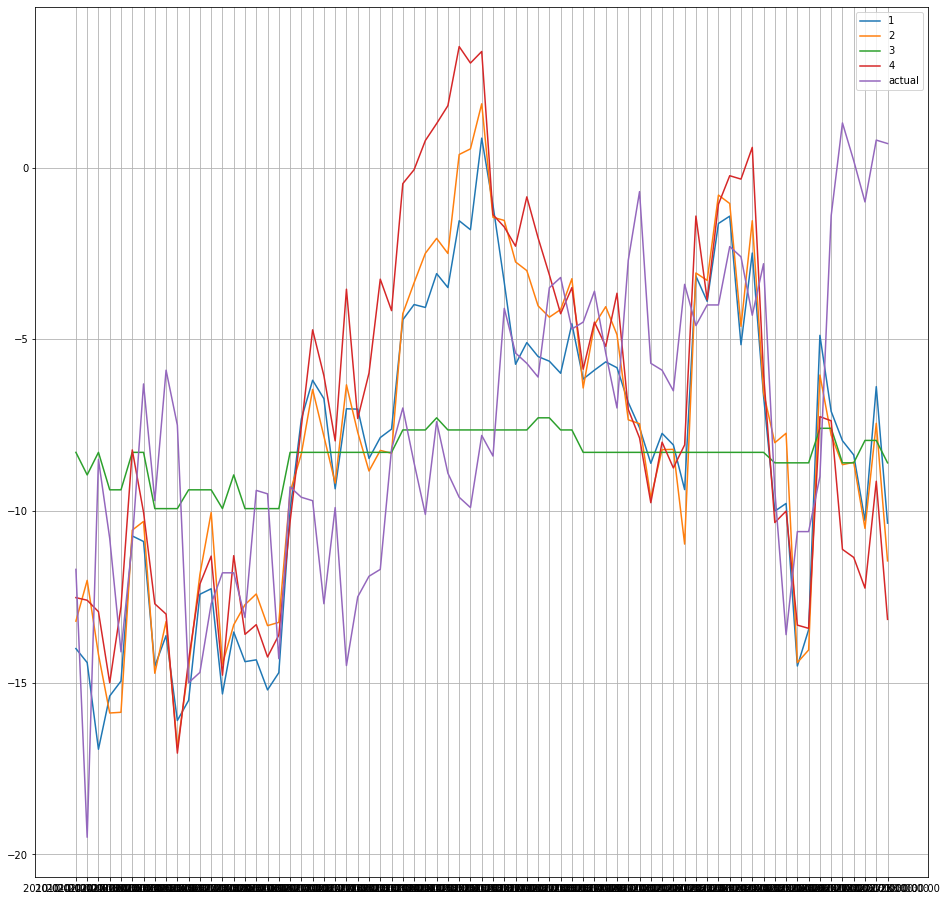

In [12]:
%matplotlib inline

plt.figure(figsize=(16,16))

for version in set(list(dataset['model_version'])):
    print(version)
    temp = dataset[dataset['stationName'] == 'NORTH BAY']
    temp = temp[temp['model_version'] == version]
    
    plt.plot(temp['datetime'], temp['temperature_prediction'], label=version)

plt.plot(temp['datetime'], temp['temperature'], label='actual')
    
plt.legend()
plt.grid()
plt.show()


In [13]:
temp.shape

(73, 27)

In [14]:
temp

,Unnamed: 0,temperature_prediction,model_name,model_version,service_name,usaf,wban,datetime,latitude,longitude,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
61475,12692,-12.522174,modelA,4,aks_cluster,717310,99999,2010-02-01 00:00:00,46.35,-79.433,...,7.0,24.0,10.0,25.0,NORTH BAY,CA,717310-99999,2010,1,1.0
61476,12693,-12.597927,modelA,4,aks_cluster,717310,99999,2010-02-01 06:00:00,46.35,-79.433,...,8.0,24.0,8.0,25.0,NORTH BAY,CA,717310-99999,2010,1,1.0
61477,12694,-12.932009,modelA,4,aks_cluster,717310,99999,2010-02-01 18:00:00,46.35,-79.433,...,8.0,24.0,6.0,25.0,NORTH BAY,CA,717310-99999,2010,1,1.0
61478,12695,-15.000435,modelA,4,aks_cluster,717310,99999,2010-02-02 00:00:00,46.35,-79.433,...,8.0,24.0,2.0,25.0,NORTH BAY,CA,717310-99999,2010,2,1.0
61479,12696,-12.785166,modelA,4,aks_cluster,717310,99999,2010-02-02 06:00:00,46.35,-79.433,...,8.0,24.0,4.0,25.0,NORTH BAY,CA,717310-99999,2010,2,1.0
61480,12697,-8.222077,modelA,4,aks_cluster,717310,99999,2010-02-03 12:00:00,46.35,-79.433,...,8.0,24.0,0.0,25.0,NORTH BAY,CA,717310-99999,2010,3,1.0
61481,12698,-10.035301,modelA,4,aks_cluster,717310,99999,2010-02-03 18:00:00,46.35,-79.433,...,7.0,24.0,6.0,25.0,NORTH BAY,CA,717310-99999,2010,3,1.0
61482,12699,-12.702640,modelA,4,aks_cluster,717310,99999,2010-02-04 18:00:00,46.35,-79.433,...,7.0,24.0,0.0,24.0,NORTH BAY,CA,717310-99999,2010,4,1.0
61483,12700,-13.002420,modelA,4,aks_cluster,717310,99999,2010-02-05 00:00:00,46.35,-79.433,...,7.0,24.0,0.0,24.0,NORTH BAY,CA,717310-99999,2010,5,1.0
61484,12701,-17.050403,modelA,4,aks_cluster,717310,99999,2010-02-05 06:00:00,46.35,-79.433,...,7.0,24.0,0.0,24.0,NORTH BAY,CA,717310-99999,2010,5,1.0
